In [1]:
import os
import re
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from sknetwork.clustering import KMeans
from sknetwork.embedding import SVD

from scipy import stats

from sklearn.cluster import KMeans as KM
from sklearn.metrics import silhouette_score

from pyiomica import frequencySubjectMatch as fs
from pyiomica.extendedDataFrame import getLombScarglePeriodogramOfDataframe 
from pyiomica.enrichmentAnalyses import ReactomeAnalysis, ExportReactomeEnrichmentReport
%matplotlib inline


Loading PyIOmica 1.3.3 (https://github.com/gmiaslab/pyiomica by G. Mias Lab)


In [2]:
def calculateLinksBetweenSubjectsByCorrelation(df1,df2,cutoff):
    '''To calculate the linked time series/Genes from two dataframes base on the pearson correlation
    
    Parameters:
        df1: pandas dataframe
            the first time series from df1
        df2: pandas dataframe
            the second time series from df2
        cutoff: float
            if the pearson correlation between two time series less than cutoff, the two time series is linked
            time series
    
    Returns:
        numlinkedGenes: integer/float
            number of linked time series
        commonGenes: integer/float
            number of common time series in df1 and df2
        linkedGenes: list of string
            the ids/names of linked time series
    
    '''
    
    idx = df1.index.intersection(df2.index)
    numlinkedGenes = 0
    linkedGenes = []
    commonGenes = len(idx)
    if commonGenes != 0:
        for r in idx:
            s1 = df1.loc[r]
            s2 = df2.loc[r]
            
            d = stats.spearmanr(s1, s2)[0]
            if d > cutoff:
                numlinkedGenes += 1
                linkedGenes.append(r)
    return numlinkedGenes, commonGenes,linkedGenes

In [3]:
### function to check if a folder exists, if not, create it
def initial_folder(folder):
    CHECK_FOLDER = os.path.isdir(folder)
# If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(folder)
    return str(folder)

In [4]:
### initial folders
resultDir = initial_folder('../results/')
frequencyDataDir = initial_folder(resultDir + 'frequencyDataframe/')
datadir = '../data/'

#data files
file1 = 'clinical_tests.txt'
file2 = 'cytokine_abundance.txt'
file3 = 'gut_16s_abundance.txt'
file4 = 'Lipidomics.csv'
file5 = 'Metabolomics.csv'
file6 = 'nares_16s_abundance.txt'
file7 = 'Proteomics.csv'
file8 = 'RNAseq_abundance.txt'
file9 = 'Transcriptomics_VST_excl_3participants.csv'

file_sameple = 'SampleInfo.csv'  ### the samples' information
file_subject = 'SubjectClass.csv'  ### the subjects diabetic class

In [ ]:
### import datasets
df_clinical = pd.read_csv(datadir+file1,sep='\t')
df_clinical.drop(['SubjectID','CollectionDate','CL1','CL2','CL3','CL4'], 1,inplace=True)
df_clinical.columns = [str(col) + '+clinical' for col in df_clinical.columns]
df_clinical.rename(columns={'VisitID+clinical': 'SampleID'}, inplace=True)

df_cytokine = pd.read_csv(datadir+file2,sep='\t')
df_cytokine.columns = [str(col) + '+cytokine' for col in df_cytokine.columns]
df_cytokine.rename(columns={'SampleID+cytokine': 'SampleID'}, inplace=True)

df_gut = pd.read_csv(datadir+file3,sep='\t')
df_gut.columns = [str(col) + '+gut' for col in df_gut.columns]
df_gut.rename(columns={'SampleID+gut': 'SampleID'}, inplace=True)

df_Lipidomics = pd.read_csv(datadir+file4)
df_Lipidomics.columns = [str(col) + '+Lipidomics' for col in df_Lipidomics.columns]
df_Lipidomics.rename(columns={'Sample_ID+Lipidomics': 'SampleID'}, inplace=True)

df_Metabolomics = pd.read_csv(datadir+file5)
df_Metabolomics.columns = [str(col) + '+Metabolomics' for col in df_Metabolomics.columns]
df_Metabolomics.rename(columns={'Unnamed: 0+Metabolomics': 'SampleID'}, inplace=True)

df_nares = pd.read_csv(datadir+file6,sep='\t')
df_nares.columns = [str(col) + '+nares' for col in df_nares.columns]
df_nares.rename(columns={'HostSampleID+nares': 'SampleID'}, inplace=True)


df_Proteomics = pd.read_csv(datadir+file7)
df_Proteomics.columns = [str(col) + '+Proteomics' for col in df_Proteomics.columns]
df_Proteomics.rename(columns={'Unnamed: 0+Proteomics': 'SampleID'}, inplace=True)

df_RNAseq = pd.read_csv(datadir+file8,sep='\t')
df_RNAseq.columns = [str(col) + '+RNAseq' for col in df_RNAseq.columns]
df_RNAseq.rename(columns={'SampleID+RNAseq': 'SampleID'}, inplace=True)

df_Transcriptomics = pd.read_csv(datadir+file9)
df_Transcriptomics.columns = [str(col) + '+Transcriptomics' for col in df_Transcriptomics.columns]
df_Transcriptomics.rename(columns={'Sample_ID+Transcriptomics': 'SampleID'}, inplace=True)

df_sample = pd.read_csv(datadir+file_sameple)
df_subject = pd.read_csv(datadir+file_subject)

In [ ]:
### create samples' time index

TimeOrder = pd.merge(df_sample, df_subject, how='outer', on=['SubjectID'])
TimeOrder['SubjectID'] = TimeOrder['SubjectID'] + '_' + TimeOrder['Class'].astype(str)
TimeOrder.drop(['Class'],1, inplace=True)
TimeOrder.rename(columns={'Days_Since_Start': 'CollectionDate'}, inplace=True)
TimeOrder.dropna(how='any',inplace = True)
TimeOrder = TimeOrder.astype({"CollectionDate": int})

TimeOrder_filter = TimeOrder.groupby('SubjectID').filter(lambda x: (len(x) > 4) & (len(x)<100) )

### get all possible time points
TimeSet = list(set(TimeOrder_filter['CollectionDate'].to_list()))
TimeSet.sort()

In [7]:
### create dataframe list
pdList = [df_clinical,df_cytokine,df_gut,df_Lipidomics,df_Metabolomics,
          df_nares,df_Proteomics,df_RNAseq,df_Transcriptomics]

dataSetList = ['clinical','cytokine','gut','Lipidomics','Metabolomics',
               'nares','Proteomics','RNAseq','Transcriptomics']

In [8]:
### function to add time index to dataframe
def add_time_order(dataframe):
    '''
    Add time frame to data

    '''
    df = pd.merge(TimeOrder, dataframe, how='outer', on=['SampleID'])
    df.dropna(subset=list(df.columns)[3:],how='all',inplace=True)
    df.dropna(subset=['CollectionDate'],inplace=True)
    df = df.astype({"CollectionDate": int})
    return df 

In [61]:
#combine datasets
index = [0,1,2,3,4,5,6,7,8]
dataSetList_dense = [dataSetList[i] for i in index]
DF_dense = [pdList[i] for i in index]
labelList = {}
for i, df in enumerate(DF_dense):
    labelList[dataSetList_dense[i]] = list(df.columns.values)
    
df_all = DF_dense[0]
df_tem = DF_dense[1:]
for df in df_tem:
    df_all = pd.merge(df_all, df, how='outer', on=['SampleID'])

In [62]:
### add time points to combined dataframe
df_All_timeOrder = add_time_order(df_all)

### group datafram by the subjects
group_df_All = df_All_timeOrder.groupby(['SubjectID'])

In [63]:
# ### seperate subject's dataframe and do LombScargle transform
# ### *********** High time cost step, It may take >3 hours for single core personal computer ******** ###
# ### To save memory, the tranformed datafram are saved

filteredID = []    #save filtered IDs
for id in group_df_All.groups.keys():
    data = deepcopy(group_df_All.get_group(id))
    data.sort_values(by=['CollectionDate'],inplace=True)
    
    ### clean data
    data.drop(['SubjectID','SampleID','CL4'], 1,inplace=True)
    data.set_index('CollectionDate',inplace=True)
    data = data.T    
    print (data.shape)
    ### data type to numberic
    for columnID in range(data.shape[1]):
        data.iloc[:,columnID] = pd.to_numeric(data.iloc[:,columnID], errors='coerce')
        
    data = data.reset_index()
    data.rename(columns={'index':'id'},inplace=True)
    data = data.loc[:,~data.columns.duplicated()]

    ### create empty dataframe with columns are all possible time points    
    DF_empty = pd.DataFrame(columns = TimeSet )
    
    if data.shape[1]-1 < 100 and data.shape[1]-1 > 4:   ### filter subjects, less than 100 and more than 4 time points
        data = data[data.count(axis=1) >=4]          ### filter omics, no less 4 non-NA values  
        if data.shape[0]>500:                        ### filter subjects, more than 500 omics record
            filteredID.append(id)
            data = data.set_index('id')
            data = DF_empty.append(data)
            data = data.astype('float')
            data.columns = data.columns.values.astype(float) - data.columns.values.astype(float)[0] # first column as reference
            
            
            ### Do LombScargle transform for each subject dataframe
            print('now do Lomb Scargle transform for subject %s' %id)
### ********** for server use, change NumberOfCPU to a larger value can save time cost ******** ###
            lombScargleDF = getLombScarglePeriodogramOfDataframe(data,NumberOfCPUs=1) 
            lombScargleDF = lombScargleDF.dropna(how='all')
            print('the transformed datafram dimension is: ', lombScargleDF.shape)
            filename = frequencyDataDir + id +'.csv'
            lombScargleDF.to_csv(filename)

In [64]:
### import transformed files from folder
onlyfiles = [f for f in os.listdir(frequencyDataDir) if os.path.isfile(os.path.join(frequencyDataDir, f))]

### create boostrap pool by combining all data frames
### save the subject IDs
bootstrap_pool = pd.DataFrame()
subject_pool = []
dflist = []

for f in onlyfiles:
    df = pd.read_csv(frequencyDataDir+f,header=0,index_col=0)
    df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0) # standard scaler
    df = df.dropna()
    #print(df.shape)
    if df.shape[0] > 500:
        bootstrap_pool = bootstrap_pool.append(df)
        subject_pool.append(f.split('.')[0])
        dflist.append(df)

In [ ]:
### bootstrap to estimate the threshold of the distance of genes between two subjects
### recommendate run it at server
### or use our recommendated value

# ### quantile of  Spearman correlation
quantile = []
for i in range(100):
    bootstrap_sample = fs.bootstrapGeneral(bootstrap_pool, 50000)
    array_bootstrap_sample = bootstrap_sample.values
    r,p = stats.spearmanr(array_bootstrap_sample, axis = 1)
    r[np.triu_indices(r.shape[0], k = 1)]
    quantile.append(np.quantile(r,0.99))

d_quantile_99 = np.mean(quantile)



In [ ]:
### build the network by compare the common genes' distance between two subjects
### if the network is saved from first running, we can skip this step to save time
### ************** High time cost step, It may take >3 hours ************* ###

edgelist = []
nodelist = []
linkedGenesDict = {}

for i in range(len(dflist)-1):

    data1 = dflist[i]
    
    for j in range(i+1,len(dflist)):
        data2 = dflist[j]        
        linked, total,linkedGenes = calculateLinksBetweenSubjectsByCorrelation(data1,data2,d_quantile_99) #using distance
            
        if linked != 0:
            edgelist.append([subject_pool[i],subject_pool[j],linked/total]) # normalize the edge
            linkedGenesDict[(subject_pool[i],subject_pool[j])] = linkedGenes

edge_df = pd.DataFrame(edgelist, columns=['source','target','weight'])

for id in subject_pool:
    nodelist.append([id,id.split('_')[1],id.split('_')[0]])
    
node_df = pd.DataFrame(nodelist, columns=['id','types','label'])

In [73]:
### we can save the network for next use to save time

linkedGenes_df = pd.DataFrame(linkedGenesDict.items(), columns=['subjects', 'linkedGenes'])
linkedGenes_df.to_csv(resultDir + 'linkedGenes.csv')
node_df.to_csv(resultDir + 'node.csv')
edge_df.to_csv(resultDir + 'edge.csv')

In [9]:
### if the network files are saved, we can reload them

node_df = pd.read_csv(resultDir + 'node.csv',header=0)
edge_df = pd.read_csv(resultDir + 'edge.csv',header=0)
linkedGenes_df = pd.read_csv(resultDir + 'linkedGenes.csv',header=0)

### from linkedGenes_df to get dict

linkedGenesDict = {}
for index, row in linkedGenes_df.iterrows():
    s = row.subjects
    g = row.linkedGenes
    linkedGenesDict[tuple(re.findall(r"'(.*?)'", s, re.DOTALL))] = re.findall(r"'(.*?)'", g, re.DOTALL)

In [10]:
# create subjects network
G = nx.from_pandas_edgelist(edge_df, 'source', 'target', 'weight')
nx.set_node_attributes(G, pd.Series(node_df.types.values, index=node_df.id).to_dict(),'types')
nx.set_node_attributes(G,  pd.Series(node_df.label.values, index=node_df.id).to_dict(),'label')

In [11]:
### embedding network to vectors
gsvd = SVD(1)  #embedding method 
A = nx.adjacency_matrix(G)
embedding = gsvd.fit_transform(A)

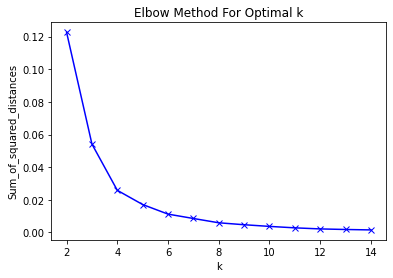

In [12]:
# find the optimazed k, we use both Elbow and Silhouette methods

Sum_of_squared_distances = []
sil = []
K = range(2,15)
for k in K:
    km = KM(n_clusters=k)
    km = km.fit(embedding)
    Sum_of_squared_distances.append(km.inertia_)
    labels = km.labels_
    sil.append(silhouette_score(embedding, labels, metric = 'euclidean'))
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [14]:
def plotCommunity(G,community,filename,figsize=(24,20),cmap=plt.cm.jet,edge_color='grey',alpha=1,
                  nodeSizeCoefficient = 100, weightThicknessCoefficient=0.1,layout = 'spring',
                  bbox_to_anchor=(1, 0.5),markerscale=3, scatterpoints=1, fontsize=10,format="PNG"):
       
    degree = dict(nx.degree(G))
    nodesize = [v * nodeSizeCoefficient for v in degree.values()]
    #labs = nx.get_node_attributes(G,'label')
    
    # color for PL method
    com_list = []
    for n in list(G.nodes()):
        com_list.append(community[n])
    if max(com_list) != 0:
        colorlist = [i/max(com_list)  for i in com_list]
    else:
        colorlist = com_list
        
    weights = nx.get_edge_attributes(G,'weight').values()
    w = []
    for wt in list(weights):
        w.append(float(wt)*weightThicknessCoefficient)
    fig, ax = plt.subplots(figsize=figsize)
    pos = eval('nx.'+ layout + '_layout(G)')
    #pos = nx.spring_layout(G)
    
    cmap=cmap
    nx.draw(G, pos,with_labels = True, node_size = nodesize, node_color = colorlist,
            edge_color=edge_color,width=w,alpha=alpha,cmap=cmap)
    comlist = list(set(colorlist))    
    comlist.sort()
    for v in comlist:
        int_v = int(v*max(com_list) + 0.5)
        plt.scatter([],[], c=[cmap(v)], label='Group{}'.format(int_v)) #make a empty plot to get legend
    plt.legend(loc='center left', bbox_to_anchor=bbox_to_anchor, markerscale=markerscale, 
               scatterpoints=scatterpoints, fontsize=fontsize)    
    plt.savefig(filename, format=format)
    
    return None

Saved: ../results_revision/Multi-subjects-Reactome-All.xlsx


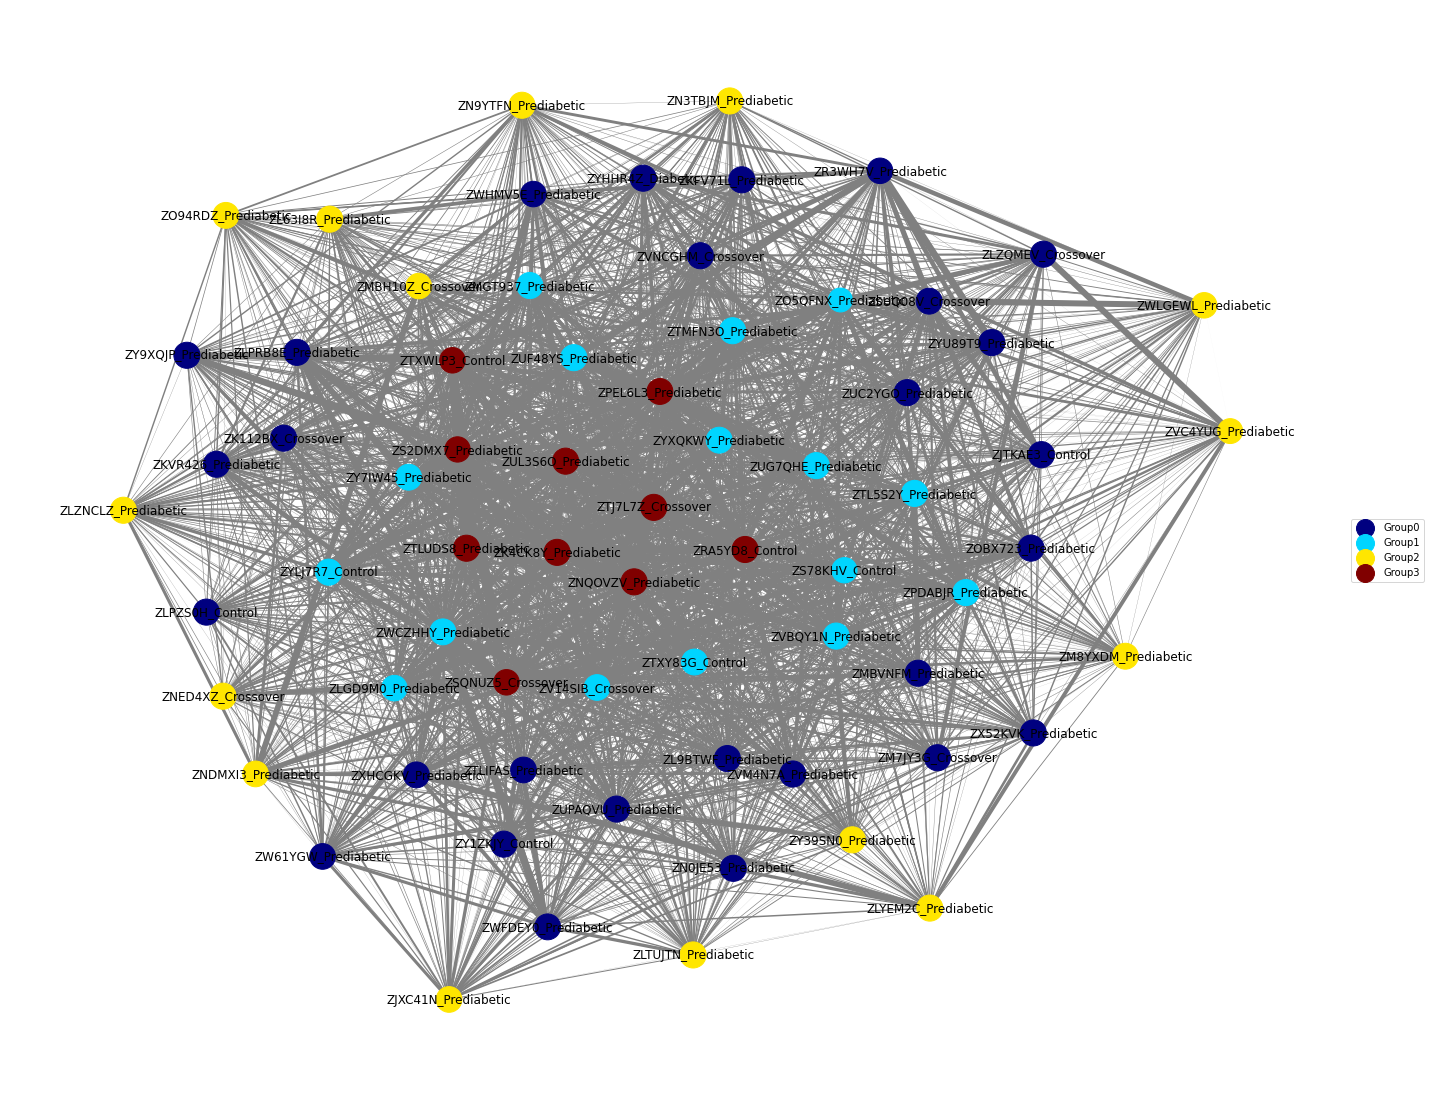

In [15]:
### we choose optimized K = 4
k_opt = 4

### choose the top quartile genes
percent = 25

### get community structure by k-Mean 
cs = {}
A = nx.adjacency_matrix(G)
kmeans = KMeans(n_clusters = k_opt, embedding_method=gsvd)
labels = kmeans.fit_transform(A)
for index, key in enumerate(list(G.nodes())):
    cs[key] = labels[index]

### save kmean community file
cs_df = pd.DataFrame(cs.items(), columns=['SubjectID', 'kmeanCommunity'])

### Reactome enrichment
community_structure = fs.getCommunityStructure(cs)
end_types_of_subject = [('Crossover','Diabetic','Prediabetic','Control')]
types_of_subject = ['All']

for i, e in enumerate(end_types_of_subject):
    community_genes_dict = fs.getCommunityTopGenesByFrequencyRanking(community_structure,linkedGenesDict,e,frequencyPercentage=percent)

    if len(community_genes_dict) != 0:
        new_community_genes_dict = fs.splitGenes(community_genes_dict)
        
        ReactomeDataFrame = ReactomeAnalysis(new_community_genes_dict)
        appstr = 'Multi-subjects-Reactome-' + types_of_subject[i]
        ExportReactomeEnrichmentReport(ReactomeDataFrame, AppendString=appstr,OutputDirectory=resultDir)
##plot network        
filename = resultDir + 'network_spring' +'.png'
plotCommunity(G,cs,filename,nodeSizeCoefficient=10,weightThicknessCoefficient=50,layout='spring')


In [17]:
cs_df.to_csv(resultDir + "community.csv",index = False)

In [18]:
###===============Below to calculate the characters of subjects in each community=============####
### import subjects status information, clear subjects visit date and state

substatusfile = 'subjectStatus.csv'
subinfofile = 'SubjectInfo.csv'
sub_status = pd.read_csv(datadir+substatusfile)
sub_status = sub_status.dropna(how='any') 
subinfo = pd.read_csv(datadir+subinfofile)

In [19]:
### get subjects healthy status string
substatus_string = pd.DataFrame(columns=['SubjectID','status','uni_status'])
sub_status_grouped = sub_status.groupby(['SubjectID'])
sub_id = sub_status_grouped.groups.keys()

### seperate subjects, ordered by collection date
for id in sub_id:
    data = sub_status_grouped.get_group(id)
    data = data.astype({"CollectionDate": float})
    sort_data = data.sort_values(by=['CollectionDate'])
    
    ### get the healthy status string
    s = ''  # status string
    us = '' # unique status string
    for index, row in sort_data.iterrows():
        add_s = row.CL4[0:2].capitalize()
        s += add_s
        if len(us) == 0:
            us += add_s
        else:
            if add_s != us[-2:]:
                us += add_s
    
    substatus_string = substatus_string.append(pd.Series([id,s,us],index=substatus_string.columns),ignore_index=True)  

In [20]:
### combine subjects healthy status and community structure information
temp_df = pd.merge(cs_df,substatus_string,how="left", on='SubjectID' )
temp_df[['SubjectID', 'Class']] = temp_df['SubjectID'].str.split('_', expand=True)

### combine with the subjects information
subjects_df = pd.merge(temp_df, subinfo,how="left", on='SubjectID')
subjects_df  = subjects_df.sort_values(by=['kmeanCommunity'])


In [21]:
###import the additional subjects' information:SSPG, Matsuda, DI, etc.
df = pd.read_csv(datadir + 'addInfo.csv')
df.drop('OGTT_Number',axis=1, inplace = True)
###for multiple measures, get the mean values
df_mean = df.groupby('SubjectID',as_index=False).mean()
### combine all subjects information
df = pd.merge(subjects_df,df_mean,how="left", on='SubjectID' )
df.to_csv(resultDir + 'subjectInfo.csv',index=False)
df.head()

,SubjectID,kmeanCommunity,status,uni_status,Class,Study,Race,Sex,Age,BMI,SSPG,IR_IS_classification,SSPG (mg/mL),Matsuda,DI,isrMax (pmol/kg/min),cluster
0,ZLPRB8E,0,HeHeHeHeHeHeHeHeHeHe,He,Prediabetic,HMP,B,F,50.90,26.86,70.0,IS,0.73,761.89,588.785,1.100,3.0
1,ZN0JE53,0,HeWeWeHeImImImImImImImHeHeHeHeHeHeHe,HeWeHeImHe,Prediabetic,HMP,B,M,66.81,33.32,148.0,IS,1.48,287.52,1584.440,6.345,1.0
2,ZWHMV5E,0,HeWeWeHeHe,HeWeHe,Prediabetic,HMP,C,F,62.80,33.96,191.0,IR,NaN,NaN,NaN,NaN,NaN
3,ZL9BTWF,0,WeHeHeHeInInInHeInInInInHeHeHeHeHeHeHeHe,WeHeInHeInHe,Prediabetic,"HMP, Exercise",C,M,64.56,26.69,99.0,IS,1.47,598.01,1142.200,5.110,4.0
4,ZLPZS0H,0,HeHeHeHeHeHeHeHeImImImImHeHe,HeImHe,Control,HMP,A,M,51.13,29.31,175.0,IR,1.80,111.45,1182.460,12.090,1.0


In [22]:
### set plot font size
plt.rcParams.update({'font.size': 11})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


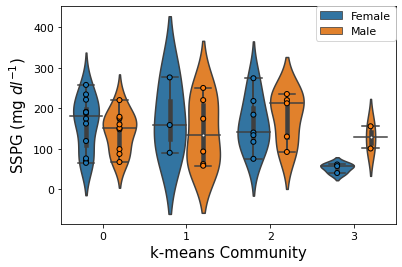

In [23]:
### plot SSPG
yv = 'SSPG'
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='kmeanCommunity', y=yv, hue='Sex',showbox=False,data=df)
sns.violinplot(x='kmeanCommunity', y=yv, hue='Sex',data=df)
sns.stripplot(y=yv, x='kmeanCommunity',
                    hue='Sex',
                    data=df,
                    dodge = True,
                    jitter=False,
                    marker='o',
                    alpha=1,
                    edgecolor='black',
                    linewidth = 1,
                    )
ax.set_xlabel('k-means Community',fontsize=15)
ax.set_ylabel(r'SSPG (mg $dl^{-1}$)', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], ['Female','Male'], bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.)
ax.figure.savefig(resultDir + "SSPG.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


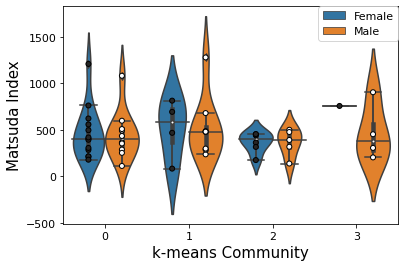

In [24]:
### plot Matsuda
yv = 'Matsuda'
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='kmeanCommunity', y=yv, hue='Sex',showbox=False, data=df)
sns.violinplot(x='kmeanCommunity', y=yv, hue='Sex',data=df)
sns.stripplot(y=yv, x='kmeanCommunity',
                    hue='Sex',
                    data=df,
                    dodge = True,
                    jitter=False,
                    marker='o',
                    alpha=1,
                    edgecolor='black',
                    linewidth = 1,
                    color="white")
ax.set_xlabel('k-means Community',fontsize=15)
ax.set_ylabel(r'Matsuda Index', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], ['Female','Male'], bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.)
ax.figure.savefig(resultDir + yv + '.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


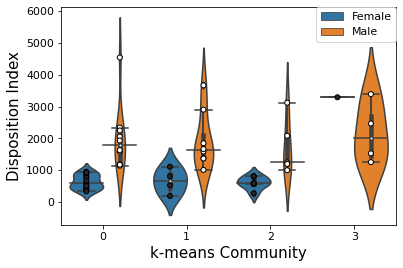

In [25]:
### plot DI
yv = 'DI'
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='kmeanCommunity', y=yv, hue='Sex',showbox=False, data=df)
sns.violinplot(x='kmeanCommunity', y=yv, hue='Sex',data=df)
sns.stripplot(y=yv, x='kmeanCommunity',
                    hue='Sex',
                    data=df,
                    dodge = True,
                    jitter=False,
                    marker='o',
                    alpha=1,
                    edgecolor='black',
                    linewidth = 1,
                    color="white")
ax.set_xlabel('k-means Community', fontsize=15)
ax.set_ylabel('Disposition Index', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], ['Female','Male'], bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.)
ax.figure.savefig(resultDir + yv + '.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


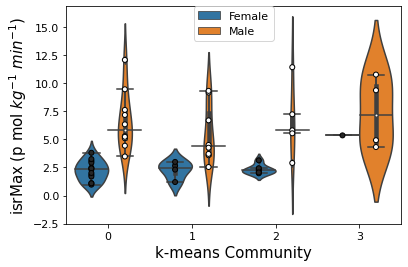

In [34]:
### plot isrMax
yv = 'isrMax (pmol/kg/min)'
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='kmeanCommunity', y=yv, hue='Sex',showbox=False, data=df)
sns.violinplot(x='kmeanCommunity', y=yv, hue='Sex',data=df)
sns.stripplot(y=yv, x='kmeanCommunity',
                    hue='Sex',
                    data=df,
                    dodge = True,
                    jitter=False,
                    marker='o',
                    alpha=1,
                    edgecolor='black',
                    linewidth = 1,
                    color="white")
ax.set_xlabel('k-means Community',fontsize=15)
ax.set_ylabel(r'isrMax (p mol $kg^{-1}$ $min^{-1}$)', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], ['Female','Male'],  loc='upper center', borderaxespad=0.)
ax.figure.savefig(resultDir + 'isrMax ' + '.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


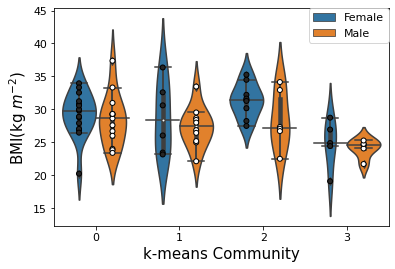

In [35]:
### plot BMI
yv = 'BMI'
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.boxplot(x='kmeanCommunity', y=yv, hue='Sex',showbox=False, data=df)
ax = sns.violinplot(x='kmeanCommunity', y=yv, hue='Sex',data=df)
ax = sns.stripplot(y=yv, x='kmeanCommunity',
                    hue='Sex',
                    data=df,
                    dodge = True,
                    jitter=False,
                    marker='o',
                    alpha=1,
                    edgecolor='black',
                    linewidth = 1,
                    color="white")
ax.set_xlabel('k-means Community',fontsize=15)
ax.set_ylabel(r'BMI(kg $m^{-2}$)', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], ['Female','Male'], bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.)
ax.figure.savefig(resultDir + yv + '.eps')

In [36]:
### do U-test
df_utest = df[['kmeanCommunity', 'Sex','BMI','SSPG','Matsuda','DI','isrMax (pmol/kg/min)']]
df_pUtest = pd.DataFrame(columns = ['G0vsG1_Female', 'G0vsG1_Male','G0vsG1_total',
                                    'G0vsG2_Female', 'G0vsG2_Male','G0vsG2_total',
                                    'G0vsG3_Female', 'G0vsG3_Male','G0vsG3_total',
                                    'G1vsG2_Female', 'G1vsG2_Male', 'G1vsG2_total',
                                    'G1vsG3_Female', 'G1vsG3_Male', 'G1vsG3_total',
                                    'G2vsG3_Female', 'G2vsG3_Male', 'G2vsG3_total',
                                   ])
# df_pUtest = pd.DataFrame(columns = ['G0vsG1_Female', 'G0vsG1_Male','G0vsG1_total',
#                                     'G0vsG2_Female', 'G0vsG2_Male','G0vsG2_total',
#                                     'G1vsG2_Female', 'G1vsG2_Male', 'G1vsG2_total',
#                                    ])


from scipy.stats import mannwhitneyu
col_list = ['BMI', 'SSPG', 'Matsuda', 'DI', 'isrMax (pmol/kg/min)']
k1 = [(0, 'F'), (0, 'M'), (1, 'F'), (1, 'M'), (2, 'F'), (2, 'M'), (3, 'F'), (3, 'M')]
k2 = [0, 1, 2, 3]
for col in col_list:
    tdf = df_utest[['kmeanCommunity', 'Sex', col]]
    g1 = tdf.groupby(['kmeanCommunity', 'Sex'])
    g2 = tdf.groupby(['kmeanCommunity'])
    plist = []
    for i in range(len(k2)-1):
        for j in range(i+1, len(k2)):
            d1a = list(g1.get_group((i,'F'))[col].dropna())
            d1b = list(g1.get_group((j,'F'))[col].dropna())
            d2a = list(g1.get_group((i,'M'))[col].dropna())
            d2b = list(g1.get_group((j,'M'))[col].dropna())  
            d3a = list(g2.get_group(i)[col].dropna())
            d3b = list(g2.get_group(j)[col].dropna())
            _, p1 = mannwhitneyu(d1a, d1b)
            _, p2 = mannwhitneyu(d2a, d2b)
            _, p3 = mannwhitneyu(d3a, d3b)
            plist.extend([p1,p2,p3])
    df_pUtest.loc[col] = plist
    
df_pUtest.to_csv(resultDir + 'pvalues_Utest.csv')

In [37]:
df_pUtest

,G0vsG1_Female,G0vsG1_Male,G0vsG1_total,G0vsG2_Female,G0vsG2_Male,G0vsG2_total,G0vsG3_Female,G0vsG3_Male,G0vsG3_total,G1vsG2_Female,G1vsG2_Male,G1vsG2_total,G1vsG3_Female,G1vsG3_Male,G1vsG3_total,G2vsG3_Female,G2vsG3_Male,G2vsG3_total
BMI,0.790985,0.598001,0.256575,0.094999,0.965006,0.189388,0.014577,0.048555,0.001731,0.388412,0.712787,0.085525,0.428571,0.019314,0.032799,0.003996,0.051948,0.000791
SSPG,0.945055,0.906102,0.820943,0.901802,0.316778,0.574520,0.004396,0.909091,0.012405,0.833333,0.583025,0.669714,0.100000,1.000000,0.082917,0.016667,0.571429,0.019392
Matsuda,0.623529,0.761826,0.497980,0.701238,0.767899,0.531437,0.428571,0.945055,0.683842,0.257143,0.523699,0.166120,0.800000,0.682828,1.000000,0.285714,1.000000,0.509615
DI,0.870588,0.896750,0.273648,0.966092,0.767899,0.970634,0.142857,0.635365,0.012780,1.000000,0.523699,0.230084,0.400000,0.933333,0.159987,0.285714,0.285714,0.008700
isrMax (pmol/kg/min),0.870588,0.274281,0.614325,0.765369,0.953047,0.912062,0.142857,1.000000,0.052890,0.914286,0.523699,0.558760,0.400000,0.153535,0.036522,0.285714,1.000000,0.145147


In [38]:
### Function to count the healthy status in a string list
def statusCount(s_list):
    sta_list = ['He', 'In', 'Im', 'We', 'An', 'Co', 'Fi', 'Po', 'Sp', 'St', 'Su'] # the healthy status abbreviations
    array_all_status = np.array(s_list), 
    status, counts = np.unique(array_all_status, return_counts=True)
    counts_status = dict(zip(status, counts))
    
    for sta in sta_list:
        if sta not in status:
            counts_status[sta] = 0
    new_counts_status = {'Healthy': counts_status['He'],
                         'Infection': counts_status['In'], 
                         'Immunization' : counts_status['Im'],
                         'Weight change' : counts_status['We'],
                         'Antibiotics' : counts_status['An'],
                         'Others' : counts_status['Co']+counts_status['Fi']+counts_status['Po']
                         +counts_status['Sp']+counts_status['St']+counts_status['Su']}
    
    return new_counts_status

In [40]:
### count different healthy status of all visits
healthyStatus_df = pd.DataFrame()
s = df.status
sub = df.Sex
chunk_size = 2    # equals to the length of a healthy status abbreviation
for i, string in enumerate(s):    
    s_list = [string[i:i+chunk_size] for i in range(0, len(string), chunk_size) ]   # split the healthy status string of a subjects
    
    counts = statusCount(s_list)
    counts['Sex'] = sub[i]
    healthyStatus_df = healthyStatus_df.append(counts, ignore_index=True)
    
# healthyStatus_df.sum()

In [ ]:
health_df = pd.DataFrame(columns = ['Count', 'Sex', 'Type'])
columns = ['Healthy', 'Infection', 'Immunization', 'Weight change', 'Antibiotics','Others']
for col in columns:
    tdf = healthyStatus_df[[col, 'Sex']]
    tdf['Type'] = col
    tdf.columns = ['Count', 'Sex', 'Type']
    health_df = pd.concat([health_df, tdf], ignore_index=True)
    
# health_df = health_df[health_df.Count != 0]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


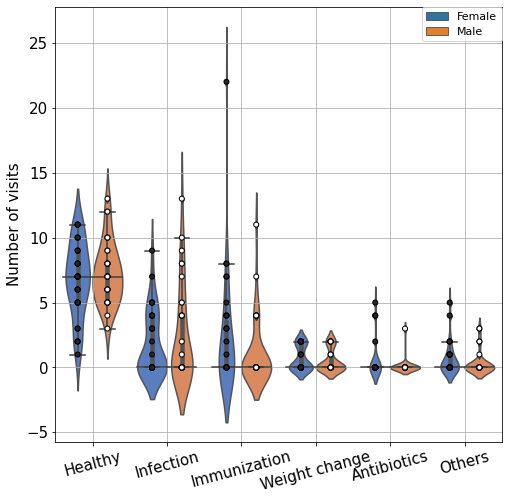

In [42]:
fig = plt.figure(figsize=(8,8))
ax = sns.boxplot(x="Type", y="Count",hue='Sex',
                 data=health_df,showbox=False)
ax = sns.violinplot(x="Type", y="Count",hue='Sex', data = health_df, palette="muted")
ax = sns.stripplot(y="Count", x="Type",
                    hue='Sex',
                    data=health_df,
                    dodge = True,
                    jitter=False,
                    marker='o',
                    alpha=1,
                    edgecolor='black',
                    linewidth = 1,
                    color="white")
ax.set_xlabel('',fontsize=15)
ax.set_ylabel('Number of visits', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], ['Female','Male'], bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.)
ax.tick_params(axis='x', rotation=15,labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.grid(True)
plt.savefig(resultDir + 'visits.eps')

In [43]:
### count different healthy status of all visits
healthyStatus_df = pd.DataFrame()
s = df.status
sub = df.SubjectID
chunk_size = 2    # equals to the length of a healthy status abbreviation
for string in s:    
    s_list = [string[i:i+chunk_size] for i in range(0, len(string), chunk_size) ]   # split the healthy status string of a subjects
    
    counts = statusCount(s_list)
    healthyStatus_df = healthyStatus_df.append(counts, ignore_index=True)
    
healthyStatus_df.sum()

Healthy          486.0
Infection        148.0
Immunization     119.0
Weight change     43.0
Antibiotics       18.0
Others            32.0
dtype: float64

In [44]:
### plot the healthy status
# outputx = healthyStatus_df.mask(healthyStatus_df == 0)
# fig = plt.figure(figsize=(8,8))
# ax = sns.boxplot(x="variable", y="value", data=pd.melt(outputx),medianprops=dict(color="red", alpha=1, linewidth=3))
# ax = sns.swarmplot(x="variable", y="value", data = pd.melt(outputx), size=4, color='black', alpha=0.7)
# ax.set_xlabel('')
# ax.set_ylabel('Number of visits',fontsize=15)
# ax.tick_params(axis='x', rotation=15,labelsize=15)
# ax.tick_params(axis='y', labelsize=15)
# ax.grid(True)
# plt.savefig(resultDir + 'visits.eps')

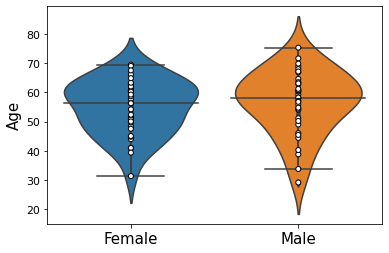

In [45]:
ax = sns.boxplot(x='Sex', y='Age',showbox=False, data=df)
ax = sns.violinplot(x='Sex', y='Age',data=df)
ax = sns.stripplot(y='Age', x='Sex',
                    data=df,
                    dodge = True,
                    jitter=False,
                    marker='o',
                    alpha=1,
                    edgecolor='black',
                    linewidth = 1,
                    color="white")
ax.set_xticklabels(['Female', 'Male'])
ax.tick_params(axis='x', labelsize=15)
ax.set_xlabel('',fontsize=15)
ax.set_ylabel('Age', fontsize=15)
plt.savefig(resultDir + 'age.eps')

In [46]:
# ### plot ages distribution
# fig, ax = plt.subplots(figsize=(8,8))
# df['Age'] = df['Age'].astype(int)
# bins_list = np.array([25,35,45,55,65,75])

# sns.histplot(data=df, x='Age', hue='Sex', multiple='stack', discrete=False,
#              edgecolor='white', bins=bins_list, alpha=1)
# plt.ylabel('Number of individuals',fontsize=15)
# plt.xlabel('Age',fontsize=15)
# plt.legend(('Female','Male'),fontsize=15)
# plt.title('')
# ax.grid(True)
# plt.savefig(resultDir + 'age.eps')